In [1]:
from fish_helpers import *

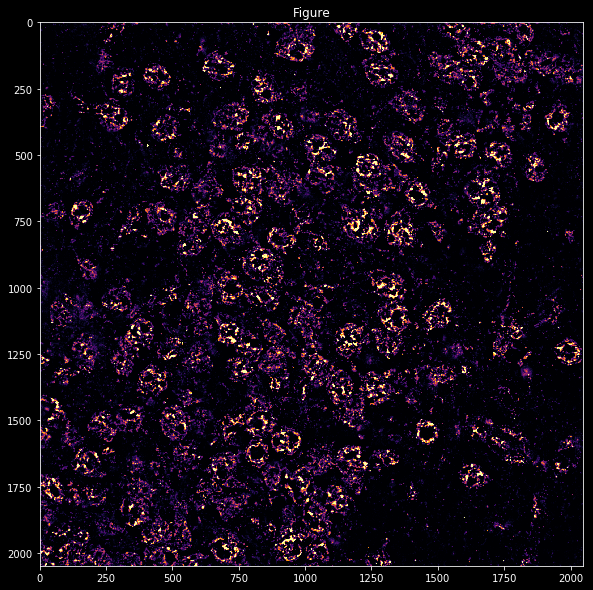

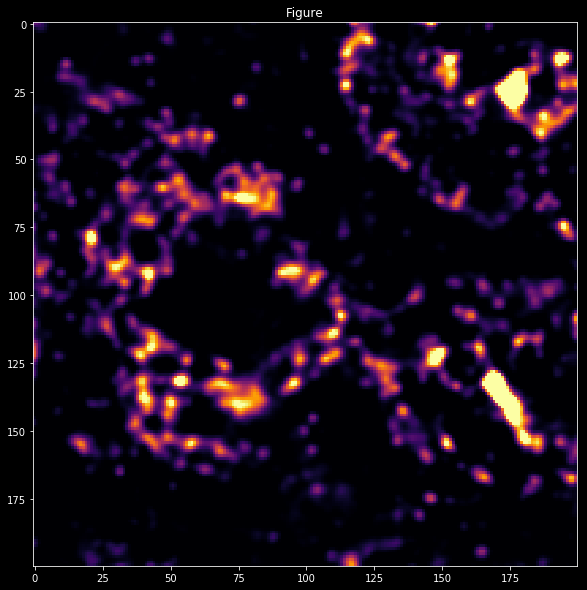

In [13]:
fishdata_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/codestacks_v1/'
posname = 'Pos1'
hdata = HybeData(os.path.join(fishdata_path,posname)'
zindex = 15
cstk = hdata.load_data(pos,zindex,'cstk')
Display(np.sum(cstk,axis=2),rel_min=50)
Display(np.sum(cstk,axis=2)[900:1100,650:850],rel_min=50)

In [3]:
from skimage.filters import gaussian
from MERFISH_Objects.FISHData import *
import os
from analysis_scripts.classify import *
cword_config = 'seqfish_config_tbi_v4'
seqfish_config = importlib.import_module(cword_config)
try:
    genes = seqfish_config.gids+seqfish_config.bids
except:
    genes = seqfish_config.gids
bitmap = seqfish_config.bitmap
normalized_gene_vectors = seqfish_config.norm_gene_codeword_vectors
normalized_all_gene_vectors = seqfish_config.norm_all_codeword_vectors
all_gene_vectors = seqfish_config.all_codeword_vectors
nbits = seqfish_config.nbits
def load_codestack(fishdata,bitmap,dataset,posname,zindex):
    cstk = np.zeros((2048,2048,len(bitmap)))
    for bitmap_idx in range(len(bitmap)):
        seq,hybe,channel = bitmap[bitmap_idx]
        temp = fishdata.load_data('image',dataset=dataset,posname=posname,hybe=hybe,channel=channel,zindex=zindex)
        if not isinstance(temp,type(None)):
            cstk[:,:,bitmap_idx] = temp
    return cstk

In [4]:
import random
from tqdm import tqdm
# Update Codeword Vectors for additional errors 
# All 18 chose 1 options
# All 18 chose 7 options
iterations = 100
low_decoys = []
low_base = list((1*"1").zfill(18))
for i in tqdm(range(iterations),total=iterations):
    random.shuffle(low_base)
    low_decoys.append(''.join(low_base))
low_decoys = list(np.unique(low_decoys))

iterations = 1000000
high_decoys = []
high_base = list((7*"1").zfill(18))
for i in tqdm(range(iterations),total=iterations):
    random.shuffle(high_base)
    high_decoys.append(''.join(high_base))
high_decoys = list(np.unique(high_decoys))

low_decoys_array = np.array([[int(i) for i in low_decoys[j]] for j in range(len(low_decoys))])
high_decoys_array = np.array([[int(i) for i in high_decoys[j]] for j in range(len(high_decoys))])

100%|██████████| 1000000/1000000 [00:27<00:00, 36909.38it/s]


In [5]:
codeword_vectors = (normalized_all_gene_vectors/np.max(normalized_all_gene_vectors)).astype(int)
codeword_vectors = np.concatenate((codeword_vectors,low_decoys_array,high_decoys_array))
genes = list(seqfish_config.gids+seqfish_config.bids)
genes.extend(['low_decoy'+str(i) for i in range(low_decoys_array.shape[0])])
genes.extend(['high_decoy'+str(i) for i in range(high_decoys_array.shape[0])])

In [6]:
from scipy.spatial.distance import cdist
def classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99):
    codeword_vectors = 0.5*(codeword_vectors>0)
    if len(cstk.shape)==3:
        mask_stk = cstk.copy()
        for i in range(cstk.shape[2]):
            mask_stk[:,:,i] = 1*(cstk[:,:,i]>np.percentile(cstk[:,:,i].ravel(),rel_peak_thresh))
        mask = (np.sum(mask_stk,axis=2)>2)&(np.sum(mask_stk,axis=2)<8)
        x,y = np.where(mask)
        vectors = cstk[x,y,:]
    else:
        vectors = cstk
    vectors = np.divide(vectors.astype('float32'), normalization_factors.astype('float32'))
    vectors = normalize(vectors, norm='l2')
    #     d = distance_matrix(codeword_vectors, vectors)
    d = cdist(codeword_vectors, vectors)
    dimg = np.nan*np.ones((cstk.shape[0],cstk.shape[1]))
    if len(cstk.shape)==3:
        dimg[x,y] = np.min(d,axis=0)
        cimg = -1*np.ones((cstk.shape[0],cstk.shape[1]))
        cimg[x,y] = np.argmin(d, axis=0)
    else:
        dimg = np.min(d,axis=0)
        cimg = np.argmin(d, axis=0)
    return dimg,cimg

In [7]:
def parse_classification_image(class_img, cstk, cvectors, genes, zindex, distance_img):
    label2d = label((class_img+1).astype('uint16'), connectivity=1)
    properties = regionprops(label2d, (class_img+1).astype('uint16'))
    areas = []
    nclasses = []
    multiclass_sets = 0
    gene_call_rows = []
    below_threshold_rows = []
    for prop in properties:
        coords = prop.coords
        centroid = prop.centroid
        classes = list(set(prop.intensity_image.flatten())-set([0]))
        if len(classes)==0:
            print('Label with no classes.')
            pdb.set_trace()
            continue
        elif not len(classes)==1:
            pdb.set_trace()
            multiclass_sets+=1
            continue
        else:
            nclasses.append(len(classes))
            areas.append(prop.area)
        codeword_idx = classes[0]-1
        gene = genes[codeword_idx]
        bits = np.where(cvectors[codeword_idx]>0)[0]
        spot_pixel_values = []
        spot_pixel_means = []
        # Calculating the mean pixel intensities for each positive bit for a single spot
        spot_nf = np.zeros(cvectors.shape[1])
        for b in bits:
            spot_bit_intensities = cstk[coords[:,0], coords[:,1], b]
            spot_nf[b] = np.mean(spot_bit_intensities)
            spot_pixel_values.append(spot_bit_intensities)
        spot_sum = np.sum(spot_pixel_values)
        spot_mean = np.mean(spot_pixel_values)
        spot_distance = np.mean(distance_img[coords[:,0], coords[:,1]])
        # If the spot is above spot_sum_thresh then add it to the gene spot list
        # the hope is to filter out background here
        gene_call_rows.append([genes[codeword_idx], spot_sum, centroid,
                        spot_mean, len(coords), codeword_idx,spot_distance])
    df = pd.DataFrame(gene_call_rows, columns=['gene', 'ssum', 'centroid', 'ave', 'npixels', 'cword_idx','cword_dist'])
    return df

In [11]:
hybedata_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/codestacks_v1/'
posnames = [i for i in os.listdir(hybedata_path) if 'Pos' in i]

In [10]:
# Generate candidate vectors for multiple positions
from tqdm import tqdm
import random
dataset = 'A4_2020Jun28'
rel_peak_thresh = 95
vector_list = []
all_df = []
normalization_factors = 1000*np.ones(nbits)
for posname in random.sample(posnames,5):
    hdata = HybeData(os.path.join(hybedata_path,posname))
    for zindex in tqdm([15,17,19,21]):
        cstk = hdata.load_data(posname,zindex,'cstk')
#         cstk = load_codestack(fishdata,bitmap,dataset,posname,zindex)
        cstk = gaussian(cstk,(1,1,0))
        max_stk = np.sum(cstk,axis=2)
        xy = np.where(max_stk>np.percentile(max_stk.ravel(),rel_peak_thresh))
        v = cstk[xy[0],xy[1],:]
        break
    break
    
#         v = cstk[xy[0],xy[1],:]
#         dimg,cimg = classify(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=rel_peak_thresh)
#         df = parse_classification_image(cimg, cstk, codeword_vectors, genes, zindex, dimg)
#         df['posname'] = posname
#         all_df.append(df)
# merged_df = pd.concat(all_df,ignore_index=True)
#         vector_list.append(vectors)
# vectors = np.concatenate(vector_list)

  0%|          | 0/4 [00:06<?, ?it/s]


In [15]:
fishdata_path = '/hybedata/Images/Robert/TBI_v2/sham_m3_slide4_2019Nov04/codestacks_v1/'
posname = 'Pos1'
hdata = HybeData(os.path.join(fishdata_path,posname))
zindex = 15
cstk = hdata.load_data(pos,zindex,'cstk')
normalization_factors = hdata.load_data(posname,zindex,'nf')
dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
df = parse_classification_image(cimg, cstk, codeword_vectors, genes, zindex, dimg)
df['posname'] = pos
df

,gene,ssum,centroid,ave,npixels,cword_idx,cword_dist,posname
0,high_decoy4549,1146.0,"(0.0, 253.5)",81.857143,2,4754,0.661377,Pos1
1,Smarcd1,913.0,"(0.0, 256.5)",114.125000,2,143,0.601517,Pos1
2,high_decoy5858,523.0,"(0.0, 361.0)",74.714286,1,6063,0.739557,Pos1
3,high_decoy5928,1210.0,"(0.5, 476.0)",86.428571,2,6133,0.565455,Pos1
4,high_decoy5864,2278.0,"(0.5, 477.5)",81.357143,4,6069,0.566113,Pos1
5,Fam178b,14167.0,"(0.375, 869.0)",442.718750,8,42,0.611232,Pos1
6,Malat1,1301.0,"(0.0, 872.0)",325.250000,1,87,0.640761,Pos1
7,Malat1,2535.0,"(0.0, 918.5)",316.875000,2,87,0.605700,Pos1
8,Epb41l4b,926.0,"(0.0, 936.0)",231.500000,1,40,0.615819,Pos1
9,Tmf1,1118.0,"(0.5, 1011.0)",139.750000,2,154,0.660730,Pos1


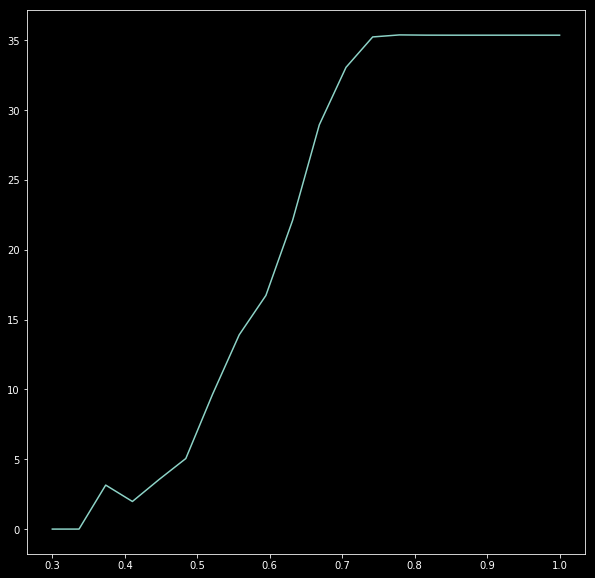

In [16]:
cword_dist_thresh = np.linspace(0.3,1,20)
blanks = [i for i in df['gene'].unique() if 'blank' in i]
decoys = [i for i in df['gene'].unique() if 'decoy' in i]
trues = [i for i in df['gene'].unique() if not ('decoy' in i)|('blank' in i)]
fpr_out = []
for cword_dist in cword_dist_thresh:
    temp = df[df['cword_dist']<cword_dist]
#     decoy_df = temp[np.isin(temp['gene'],decoys)]
    blank_df = temp[np.isin(temp['gene'],blanks)]
    true_df = temp[np.isin(temp['gene'],trues)]
    blank_count = len(blank_df)
#     decoy_count = len(decoy_df)
    true_count = len(true_df)
    fpr = round(100*(blank_count/len(blanks))/((true_count+blank_count)/(len(blanks)+len(trues))),3)
#     print(fpr,'% ',true_count)
    fpr_out.append(fpr)
plt.figure(figsize=[10,10])
plt.plot(cword_dist_thresh,fpr_out)
plt.show()

In [17]:
true_count

11714

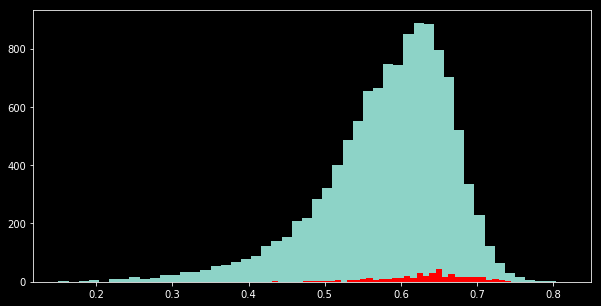

In [18]:
plt.figure(figsize=[10,5])
plt.hist(true_df.cword_dist,bins=50)
plt.hist(blank_df.cword_dist,bins=50,color='r')
plt.show()

In [19]:
blank_indexes = [i for i,gene in enumerate(genes) if 'blank' in gene]
true_indexes = [i for i,gene in enumerate(genes) if not ('blank' in gene)|('decoy' in gene)]

In [20]:
def calculate_fpr(cimg,genes,codeword_vectors):
    blank_indexes = [i for i,gene in enumerate(genes) if 'blank' in gene]
    true_indexes = [i for i,gene in enumerate(genes) if not ('blank' in gene)|('decoy' in gene)]
    
    b_xy = np.where(np.isin(cimg,blank_indexes))
    # blank_vectors = cstk[b_xy[0],b_xy[1],:]
    blank_cimg = cimg[b_xy[0],b_xy[1]].astype(int)
    blank_codewords = codeword_vectors[blank_cimg,:]
    blank_counts = np.sum(blank_codewords,axis=0)

    t_xy = np.where(np.isin(cimg,true_indexes))
    # true_vectors = cstk[t_xy[0],t_xy[1],:]
    true_cimg = cimg[t_xy[0],t_xy[1]].astype(int)
    true_codewords = codeword_vectors[true_cimg,:]
    true_counts = np.sum(true_codewords,axis=0)

    correction = (len(true_indexes)+len(blank_indexes))/len(blank_indexes)
    bit_fpr = correction*(blank_counts)/(true_counts+blank_counts)
    total_fpr = correction*blank_cimg.shape[0]/true_cimg.shape[0]
    total_counts = true_cimg.shape[0]
    return bit_fpr,total_fpr,total_counts
# calculate_fpr(cimg,genes,codeword_vectors)

In [22]:
import time
start = time.time()
pos = 'Pos1'
z = 17
scaling_factor = 0.3
ideal = 0.05
normalization_factors = hdata.load_data(posname,zindex,'nf')
# normalization_factors = 1000*np.ones(cstk.shape[2])
iterations = 10
nf_out = np.zeros((iterations+1,normalization_factors.shape[0]))
bit_fpr_out = np.zeros((iterations,normalization_factors.shape[0]))
total_fpr_out = np.zeros(iterations)
total_counts_out = np.zeros(iterations)
cstk = hdata.load_data(pos,zindex,'cstk')
# cstk = load_codestack(fishdata,bitmap,dataset,pos,z)
for i in tqdm(range(iterations)):
    nf_out[i,:] = normalization_factors
    dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
    bit_fpr,total_fpr,total_counts = calculate_fpr(cimg,genes,codeword_vectors)
    normalization_factors = normalization_factors+normalization_factors*(scaling_factor*(bit_fpr-ideal))
    bit_fpr_out[i,:] = bit_fpr
    total_fpr_out[i] = total_fpr
    total_counts_out[i] = total_counts
    print('iteration',i)
    print('bit fpr',[str(round(100*i))+'%' for i in bit_fpr])
    print('total fpr',total_fpr)
    print('total counts',total_counts)
    print('nf',[int(i) for i in normalization_factors])
# df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)

print(time.time()-start)

 10%|█         | 1/10 [02:07<19:06, 127.41s/it]

iteration 0
bit fpr ['1%', '41%', '17%', '14%', '21%', '0%', '18%', '35%', '27%', '3%', '60%', '3%', '5%', '33%', '74%', '4%', '42%', '21%']
total fpr 0.15106819401053995
total counts 52815
nf [124, 39, 42, 11, 50, 48, 39, 58, 55, 59, 80, 59, 76, 51, 14, 75, 81, 84]


 20%|██        | 2/10 [04:14<16:59, 127.41s/it]

iteration 1
bit fpr ['1%', '39%', '14%', '11%', '22%', '1%', '15%', '24%', '22%', '2%', '40%', '2%', '6%', '36%', '57%', '7%', '33%', '15%']
total fpr 0.11929328229877406
total counts 54081
nf [122, 43, 43, 11, 53, 48, 40, 61, 58, 59, 89, 58, 76, 56, 16, 75, 88, 87]


 30%|███       | 3/10 [06:22<14:51, 127.37s/it]

iteration 2
bit fpr ['1%', '37%', '11%', '9%', '19%', '1%', '14%', '18%', '20%', '2%', '30%', '2%', '6%', '36%', '47%', '8%', '27%', '11%']
total fpr 0.0994512534145575
total counts 55156
nf [121, 48, 44, 12, 55, 47, 41, 64, 60, 58, 95, 58, 76, 61, 18, 76, 93, 88]


 40%|████      | 4/10 [08:29<12:43, 127.32s/it]

iteration 3
bit fpr ['2%', '32%', '9%', '7%', '17%', '1%', '12%', '15%', '18%', '1%', '25%', '2%', '5%', '32%', '41%', '9%', '22%', '9%']
total fpr 0.08429532142885449
total counts 56076
nf [120, 52, 45, 12, 57, 46, 42, 65, 63, 58, 101, 57, 76, 66, 20, 77, 98, 89]


 50%|█████     | 5/10 [10:36<10:36, 127.31s/it]

iteration 4
bit fpr ['2%', '31%', '8%', '6%', '16%', '1%', '13%', '12%', '15%', '1%', '21%', '2%', '4%', '31%', '39%', '10%', '18%', '8%']
total fpr 0.07623161883310751
total counts 56829
nf [118, 56, 45, 12, 59, 46, 43, 67, 64, 57, 106, 57, 76, 71, 22, 78, 102, 90]


 60%|██████    | 6/10 [12:47<08:33, 128.26s/it]

iteration 5
bit fpr ['2%', '30%', '7%', '6%', '15%', '2%', '13%', '11%', '14%', '1%', '19%', '2%', '4%', '28%', '36%', '11%', '15%', '7%']
total fpr 0.06884127287800523
total counts 57497
nf [117, 60, 45, 12, 61, 45, 44, 68, 66, 56, 111, 56, 76, 76, 25, 80, 105, 91]


 70%|███████   | 7/10 [14:54<06:24, 128.01s/it]

iteration 6
bit fpr ['2%', '26%', '6%', '5%', '13%', '2%', '12%', '10%', '13%', '1%', '17%', '1%', '3%', '24%', '32%', '11%', '13%', '6%']
total fpr 0.05936814484588036
total counts 58097
nf [116, 64, 45, 12, 62, 45, 45, 69, 68, 56, 115, 55, 76, 80, 27, 81, 108, 91]


 80%|████████  | 8/10 [17:01<04:15, 127.83s/it]

iteration 7
bit fpr ['2%', '24%', '6%', '4%', '12%', '2%', '12%', '9%', '12%', '1%', '15%', '2%', '3%', '22%', '31%', '11%', '12%', '6%']
total fpr 0.054744567040138255
total counts 58639
nf [115, 67, 45, 12, 64, 45, 46, 70, 69, 55, 118, 55, 75, 85, 29, 82, 110, 91]


 90%|█████████ | 9/10 [19:09<02:07, 127.70s/it]

iteration 8
bit fpr ['2%', '21%', '5%', '4%', '12%', '2%', '13%', '8%', '12%', '1%', '14%', '2%', '2%', '20%', '31%', '11%', '11%', '5%']
total fpr 0.05186006197072936
total counts 59096
nf [114, 71, 45, 12, 65, 44, 47, 71, 71, 54, 121, 54, 74, 88, 31, 84, 112, 92]


100%|██████████| 10/10 [21:16<00:00, 127.68s/it]

iteration 9
bit fpr ['2%', '19%', '5%', '3%', '12%', '2%', '13%', '8%', '12%', '1%', '13%', '1%', '2%', '18%', '30%', '11%', '10%', '5%']
total fpr 0.047842073909738915
total counts 59499
nf [113, 74, 45, 12, 66, 44, 48, 71, 72, 53, 124, 54, 74, 92, 33, 86, 114, 92]
1276.7614028453827


In [24]:
for i in tqdm([10,11,12,13,14,15,16,17,18,19]):
    dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
    bit_fpr,total_fpr,total_counts = calculate_fpr(cimg,genes,codeword_vectors)
    normalization_factors = normalization_factors+normalization_factors*(scaling_factor*(bit_fpr-ideal))
    print('iteration',i)
    print('bit fpr',[str(round(100*i))+'%' for i in bit_fpr])
    print('total fpr',total_fpr)
    print('total counts',total_counts)
    print('nf',[int(i) for i in normalization_factors])

 10%|█         | 1/10 [01:31<13:40, 91.12s/it]

iteration 10
bit fpr ['13%', '69%', '21%', '21%', '9%', '11%', '7%', '28%', '25%', '9%', '59%', '1%', '77%', '27%', '6%', '26%', '19%', '14%']
total fpr 0.16512465004666044
total counts 37505
nf [1562, 13980, 3156, 16091, 2356, 1753, 1615, 3202, 3231, 2301, 11042, 1165, 16198, 3607, 1110, 3362, 2326, 2155]


 20%|██        | 2/10 [03:02<12:08, 91.12s/it]

iteration 11
bit fpr ['12%', '65%', '19%', '17%', '8%', '9%', '7%', '26%', '24%', '7%', '53%', '1%', '74%', '26%', '5%', '24%', '16%', '13%']
total fpr 0.14741902562174355
total counts 37234
nf [1595, 16496, 3290, 16657, 2376, 1776, 1622, 3407, 3411, 2316, 12620, 1151, 19531, 3838, 1109, 3549, 2406, 2203]


 30%|███       | 3/10 [04:33<10:37, 91.09s/it]

iteration 12
bit fpr ['12%', '63%', '17%', '13%', '7%', '9%', '5%', '25%', '22%', '7%', '48%', '1%', '66%', '24%', '4%', '23%', '16%', '12%']
total fpr 0.13241181562432375
total counts 36968
nf [1627, 19348, 3405, 17060, 2387, 1795, 1624, 3610, 3581, 2327, 14238, 1136, 23121, 4059, 1106, 3738, 2483, 2248]


 40%|████      | 4/10 [06:04<09:06, 91.08s/it]

iteration 13
bit fpr ['10%', '59%', '15%', '11%', '6%', '8%', '5%', '23%', '20%', '6%', '49%', '1%', '66%', '23%', '3%', '21%', '14%', '11%']
total fpr 0.12104704055784055
total counts 36713
nf [1653, 22511, 3509, 17376, 2395, 1810, 1624, 3809, 3746, 2334, 16119, 1120, 27363, 4275, 1101, 3922, 2549, 2286]


 50%|█████     | 5/10 [07:35<07:35, 91.09s/it]

iteration 14
bit fpr ['9%', '53%', '14%', '7%', '5%', '7%', '4%', '21%', '18%', '5%', '44%', '0%', '63%', '21%', '3%', '19%', '13%', '9%']
total fpr 0.10610544776937411
total counts 36492
nf [1673, 25749, 3607, 17473, 2398, 1820, 1621, 3997, 3892, 2335, 18020, 1105, 32088, 4476, 1094, 4085, 2611, 2316]


 60%|██████    | 6/10 [09:06<06:04, 91.06s/it]

iteration 15
bit fpr ['8%', '50%', '13%', '5%', '5%', '6%', '4%', '20%', '16%', '5%', '40%', '0%', '60%', '19%', '3%', '18%', '13%', '8%']
total fpr 0.09629138707094137
total counts 36213
nf [1689, 29246, 3695, 17475, 2398, 1826, 1616, 4178, 4022, 2334, 19906, 1089, 37370, 4667, 1087, 4239, 2676, 2340]


 70%|███████   | 7/10 [10:37<04:33, 91.07s/it]

iteration 16
bit fpr ['8%', '50%', '13%', '4%', '5%', '6%', '4%', '20%', '16%', '4%', '37%', '0%', '59%', '19%', '3%', '17%', '14%', '8%']
total fpr 0.09271210013908206
total counts 35950
nf [1705, 33161, 3784, 17430, 2395, 1830, 1609, 4367, 4153, 2330, 21820, 1073, 43411, 4867, 1081, 4393, 2744, 2363]


 80%|████████  | 8/10 [12:08<03:02, 91.05s/it]

iteration 17
bit fpr ['7%', '47%', '13%', '4%', '4%', '5%', '4%', '19%', '15%', '4%', '35%', '0%', '58%', '19%', '3%', '16%', '13%', '7%']
total fpr 0.08616830796777082
total counts 35744
nf [1717, 37328, 3871, 17383, 2391, 1832, 1602, 4552, 4276, 2324, 23803, 1057, 50268, 5067, 1073, 4534, 2811, 2380]


 90%|█████████ | 9/10 [13:39<01:31, 91.01s/it]

iteration 18
bit fpr ['7%', '47%', '13%', '5%', '4%', '5%', '3%', '19%', '14%', '4%', '33%', '0%', '57%', '19%', '2%', '15%', '13%', '7%']
total fpr 0.08342496264343512
total counts 35469
nf [1728, 42060, 3961, 17378, 2386, 1832, 1595, 4740, 4397, 2316, 25790, 1042, 58143, 5276, 1065, 4675, 2881, 2395]


100%|██████████| 10/10 [15:10<00:00, 91.05s/it]

iteration 19
bit fpr ['6%', '48%', '13%', '3%', '4%', '5%', '3%', '17%', '12%', '4%', '29%', '0%', '59%', '18%', '2%', '14%', '13%', '7%']
total fpr 0.07758767208656733
total counts 35302
nf [1733, 47476, 4054, 17286, 2378, 1831, 1588, 4906, 4495, 2307, 27672, 1026, 67545, 5476, 1056, 4808, 2947, 2409]


In [23]:
hip = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/GSE74985_genes.fpkm_tracking',sep='\t')
hip_fpkm = pd.DataFrame(index = hip.gene_short_name)
for column in hip.columns:
    if 'FPKM' in column:
        hip_fpkm[column] = list(hip[column])
hip_fpkm['average'] = np.average(hip_fpkm,axis=1)
hip_fpkm.index = [i.capitalize() for i in hip_fpkm.index]
hip_fpkm

,dg_d_FPKM,dg_v_FPKM,ca4_FPKM,ca3_d_FPKM,ca3_v_FPKM,ca2_FPKM,ca1_d_FPKM,ca1_v_FPKM,average
Gnai3,8.131250,11.763400,10.673600,18.301500,10.505900,10.719200,7.859310,9.818570,10.971591
Pbsn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cdc45,0.000000,2.597860,1.023760,0.621743,1.248480,2.207520,0.201932,1.372640,1.159242
H19,0.000000,0.000000,0.008192,0.178003,0.000000,0.000000,0.000000,0.000000,0.023274
Scml2,0.011255,0.303125,0.039321,0.031681,0.185555,0.697320,0.011220,0.088365,0.170980
Apoh,0.274916,0.000000,0.366076,0.081461,0.092551,0.456340,0.224091,0.040771,0.192026
Narf,5.531830,10.624300,9.831120,11.153400,13.312800,15.688000,13.457800,17.622100,12.152669
Cav2,0.000000,0.200999,0.184143,1.096210,0.505523,0.989240,0.151403,2.007550,0.641884
Klf6,10.621200,5.951590,31.429300,13.190100,10.211400,13.252100,11.816600,21.363500,14.729474
Scmh1,35.827500,32.167900,25.838900,26.231200,26.452000,24.758400,32.322000,27.729400,28.915912


In [27]:
from scipy.stats import pearsonr
def hipcorrelation(df):
    c = []
    s = []
    for gn,cc in Counter(df.gene).items():
        if gn in shared_genes:
            c.append(cc)
            ts = hip_fpkm['average'].loc[gn]
            if isinstance(ts,float):
                s.append(ts)
            else:
                s.append(ts.iloc[0])
    print(len(df)/len(df.posname.unique()))
    print(pearsonr(c,s))
    print(spearmanr(c,s))
    plt.scatter(np.log10(np.array(c)+1),np.log10(np.array(s)+1))
    plt.ylabel('bulk hippocampus rnaseq')
    plt.show()

12717.0
12717.0
(0.8517576313028191, 1.2043089129052462e-45)
SpearmanrResult(correlation=0.3047833817238985, pvalue=9.872617724533855e-05)


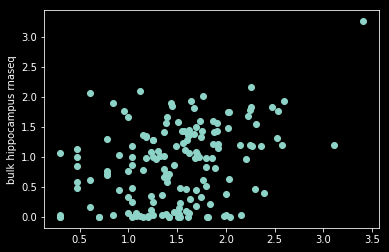

In [28]:
fpkm = hip_fpkm
# df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)
df['posname'] = pos
true_df = df[(np.isin(df['cword_idx'],true_indexes))]
temp = true_df#[(true_df.cword_dist<0.7)]#[true_df['npixels']>1]#df[(df.npixels>1)&(df.ave>10**2.9)&(df.cword_dist<0.52)]
print(len(temp)/len(df.posname.unique()))
hipcorrelation(temp)

In [29]:
normalization_factors

array([113.76198119,  74.0347614 ,  45.98505317,  12.02744027,
        66.94681541,  44.11953079,  48.49902668,  71.70331059,
        72.78537858,  53.79157207, 124.89619412,  54.25108948,
        74.28355441,  92.44496165,  33.88624136,  86.13057521,
       114.33604791,  92.08727922])

In [30]:
decoy_indexes = [i for i,gene in enumerate(genes) if ('decoy' in gene)]
df[(np.isin(df['cword_idx'],decoy_indexes)==False)]

,gene,ssum,centroid,ave,npixels,cword_idx,cword_dist,posname
3,Smarcd1,467.0,"(0.0, 257.0)",116.750000,1,143,0.604213,Pos1
5,Samm50,3647.0,"(1.3333333333333333, 476.55555555555554)",101.305556,9,132,0.597433,Pos1
6,Ppp1r9a,679.0,"(0.5, 478.0)",84.875000,2,118,0.607177,Pos1
7,Malat1,1225.0,"(0.0, 867.0)",306.250000,1,87,0.649003,Pos1
8,Fam178b,4235.0,"(0.0, 868.5)",529.375000,2,42,0.669890,Pos1
9,Malat1,9396.0,"(0.5, 870.5)",391.500000,6,87,0.630867,Pos1
10,Malat1,2535.0,"(0.0, 918.5)",316.875000,2,87,0.582158,Pos1
11,Malat1,905.0,"(0.0, 936.0)",226.250000,1,87,0.596563,Pos1
12,Tmf1,1118.0,"(0.5, 1011.0)",139.750000,2,154,0.628911,Pos1
14,Smarcd1,624.0,"(0.0, 1087.0)",156.000000,1,143,0.680609,Pos1


In [55]:
hdata.metadata[hdata.metadata.dtype=='cstk'].zindex.unique()

array(['3', '5', '7', '9', '11', '13', '15', '17', '19', '21', '23', '25',
       '27', '29'], dtype=object)

In [56]:
# Generate candidate vectors for multiple positions
from tqdm import tqdm
import random
dataset = 'A4_2020Jun28'
rel_peak_thresh = 99
vector_list = []
all_df = []
all_df.append(df[(np.isin(df['cword_idx'],decoy_indexes)==False)])
# normalization_factors = 1000*np.ones(nbits)
for posname in random.sample(posnames,50):
    hdata = HybeData(os.path.join(hybedata_path,posname))
    for zindex in tqdm(hdata.metadata[hdata.metadata.dtype=='cstk'].zindex.unique(),desc=posname):
        cstk = hdata.load_data(posname,zindex,'cstk')
        cstk = gaussian(cstk,(1,1,0))
        dimg,cimg = classify_pixels(cstk,normalization_factors,codeword_vectors,rel_peak_thresh=99)
        df = parse_classification_image(cimg, cstk, codeword_vectors, genes, zindex, dimg)
        df['posname'] = posname
        df = df[(np.isin(df['cword_idx'],decoy_indexes)==False)]
        all_df.append(df)
merged_df = pd.concat(all_df,ignore_index=True)

Pos20:  29%|██▊       | 4/14 [11:16<28:11, 169.17s/it]


KeyboardInterrupt: 

In [57]:
merged_df = pd.concat(all_df,ignore_index=True)

20027.7
20027.7
(0.9572978166724211, 5.594094289976396e-86)
SpearmanrResult(correlation=0.2708862783371793, pvalue=0.0005762663777953415)


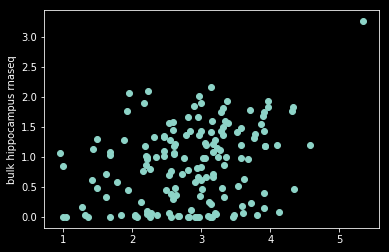

In [63]:
fpkm = hip_fpkm
# df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)
df = merged_df
true_df = df[(np.isin(df['cword_idx'],true_indexes))]
temp = true_df[(true_df.cword_dist<0.6)&(true_df['npixels']>2)]#df[(df.npixels>1)&(df.ave>10**2.9)&(df.cword_dist<0.52)]
print(len(temp)/len(df.posname.unique()))
hipcorrelation(temp)

3065.6666666666665
3065.6666666666665
(0.9829888318187632, 7.300439366768896e-94)
SpearmanrResult(correlation=0.23985404691899334, pvalue=0.006606422860805899)


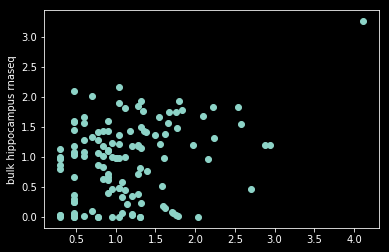

In [52]:
fpkm = hip_fpkm
# df = parse_classification_image(cimg, cstk, codeword_vectors, genes, z, dimg)
df = merged_df
true_df = df[(np.isin(df['cword_idx'],true_indexes))]
temp = true_df[(true_df.cword_dist<0.6)&(true_df['npixels']>2)]#df[(df.npixels>1)&(df.ave>10**2.9)&(df.cword_dist<0.52)]
print(len(temp)/len(df.posname.unique()))
hipcorrelation(temp)

In [48]:
merged_df.head()

,gene,ssum,centroid,ave,npixels,cword_idx,cword_dist,posname
0,Smarcd1,467.0,"(0.0, 257.0)",116.750000,1,143,0.604213,Pos1
1,Samm50,3647.0,"(1.3333333333333333, 476.55555555555554)",101.305556,9,132,0.597433,Pos1
2,Ppp1r9a,679.0,"(0.5, 478.0)",84.875000,2,118,0.607177,Pos1
3,Malat1,1225.0,"(0.0, 867.0)",306.250000,1,87,0.649003,Pos1
4,Fam178b,4235.0,"(0.0, 868.5)",529.375000,2,42,0.669890,Pos1


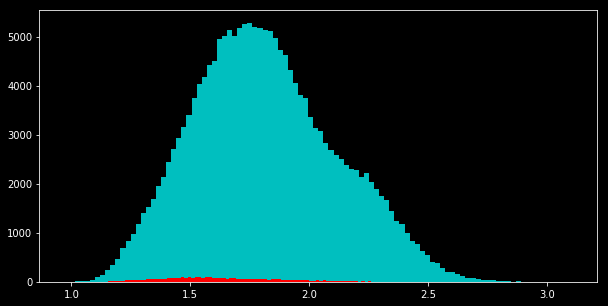

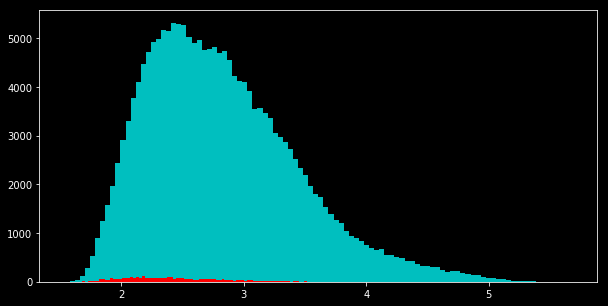

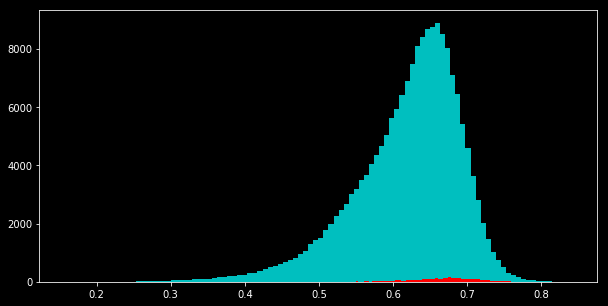

In [34]:
blank_df = merged_df[np.isin(merged_df['cword_idx'],blank_indexes)]
true_df = merged_df[np.isin(merged_df['cword_idx'],true_indexes)]
plt.figure(figsize=[10,5])
plt.hist(np.log10(true_df['ave']+1),bins=100,color='c')
plt.hist(np.log10(blank_df['ave']+1),bins=100,color='r')
plt.show()
plt.figure(figsize=[10,5])
plt.hist(np.log10(true_df['ssum']+1),bins=100,color='c')
plt.hist(np.log10(blank_df['ssum']+1),bins=100,color='r')
plt.show()
plt.figure(figsize=[10,5])
plt.hist(true_df['cword_dist'],bins=100,color='c')
plt.hist(blank_df['cword_dist'],bins=100,color='r')
plt.show()

In [69]:
hip_fpkm.loc[shared_genes]

,dg_d_FPKM,dg_v_FPKM,ca4_FPKM,ca3_d_FPKM,ca3_v_FPKM,ca2_FPKM,ca1_d_FPKM,ca1_v_FPKM,average
Pparg,0.027722,1.116320,0.236007,1.150580,0.687363,0.111137,0.000000,0.237639,0.445846
Necab1,2.036450,29.765600,190.412000,5.385800,109.293000,0.486254,2.873740,35.025600,46.909805
Grm2,62.990800,17.347800,1.916130,0.044962,1.289510,0.345202,0.043285,4.898230,11.109490
Kctd12,0.014342,0.000000,0.000000,0.000000,0.000000,0.004697,0.000000,0.000000,0.002380
Pik3ip1,5.867650,11.114400,4.914800,5.876980,8.533850,4.361450,1.837580,8.434090,6.367600
Dyrk1a,42.848600,42.149000,30.270300,34.721200,32.314500,33.344900,31.695000,37.700600,35.630513
Creb1,28.205400,48.714300,17.539200,48.357000,40.284900,37.913400,57.200500,37.100600,39.414412
Trappc8,16.232100,12.532600,10.644100,14.304500,13.200900,16.213400,16.046500,15.146900,14.290125
Pnoc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045586,0.005698
Frmd4a,21.339800,23.156500,14.688200,10.521400,17.115600,13.993300,11.222800,13.009800,15.630925


In [70]:
spearmanr(hip_fpkm['dg_d_FPKM'].loc[shared_genes],hip_fpkm['ca1_v_FPKM'].loc[shared_genes])

SpearmanrResult(correlation=0.7659182910099311, pvalue=1.6603383007758547e-32)

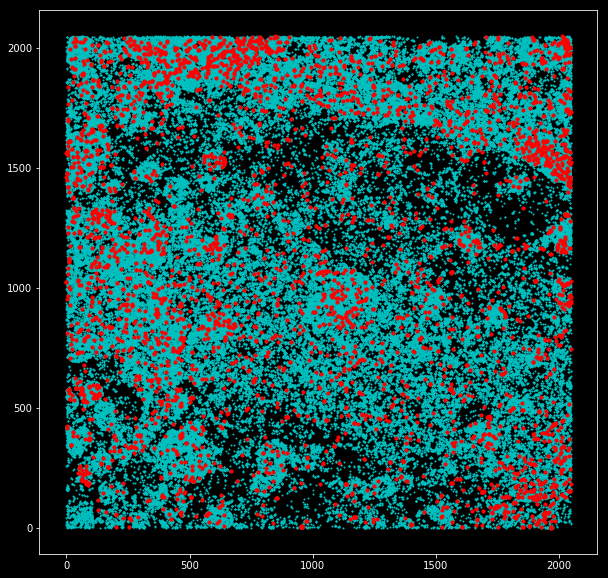

In [35]:
plt.figure(figsize=[10,10])
xy = np.stack(true_df['centroid'])
plt.scatter(xy[:,0],xy[:,1],c='c',s=1)
xy = np.stack(blank_df['centroid'])
plt.scatter(xy[:,0],xy[:,1],c='r',s=10)
plt.show()

In [64]:
correction = (len(blank_indexes)+len(true_indexes))/len(blank_indexes)
temp = merged_df[merged_df['npixels']>1]
blank_df = temp[np.isin(temp['cword_idx'],blank_indexes)]
true_df = temp[np.isin(temp['cword_idx'],true_indexes)]
correction*(len(blank_df)/(len(blank_df)+len(true_df)))

0.14741878084126722

In [ ]:
plt.figure(figsize=[10,5])
plt.bar()